Load the images

In [1]:
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map
from utils.DataManager import DynamicGaussianDatasetManager


device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)

dataset_path = "/mnt/c/MyFiles/Datasets/dynamic/data/basketball"
dataset = DynamicGaussianDatasetManager(dataset_path, device='cuda', dataset='dynamic', mode='train_test')
image_names = dataset.file_names(1, train=True)
# Load and preprocess example images (replace with your own image paths)

images = load_and_preprocess_images(image_names).to(device)

In [2]:
images.shape

torch.Size([27, 3, 294, 518])

In [3]:
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        # Predict attributes including cameras, depth maps, and point maps.
        predictions = model(images)

/tmp/ipykernel_1173079/679868208.py:2: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):
/home/anurag/codes/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [4]:
predictions.keys()

dict_keys(['pose_enc', 'depth', 'depth_conf', 'world_points', 'world_points_conf', 'images'])

In [5]:
extrinsic, intrinsic = pose_encoding_to_extri_intri(predictions['pose_enc'], images.shape[-2:])

In [6]:
extrinsic.shape, intrinsic.shape

(torch.Size([1, 27, 3, 4]), torch.Size([1, 27, 3, 3]))

In [7]:
intrinsic = intrinsic.squeeze()
extrinsic = extrinsic.squeeze()

In [8]:
from diff_gaussian_rasterization_with_depth import GaussianRasterizationSettings as Camera
near=0.01
far=100
w = images.shape[-1]
h = images.shape[-2]
def setup_camera(i):
    fx = intrinsic[i, 0, 0]
    fy = intrinsic[i, 1, 1]
    cx = intrinsic[i, 0, 2]
    cy = intrinsic[i, 1, 2]
    w2c = extrinsic[i, :, :]
    w2c = torch.cat([w2c, torch.tensor([[0, 0, 0, 1]], device=w2c.device, dtype=w2c.dtype)], dim=0)
    cam_center = torch.linalg.inv(w2c)[:3, 3]
    w2c = w2c.unsqueeze(0).transpose(1, 2)
    opengl_proj = torch.tensor([[2 * fx / w, 0.0, -(w - 2 * cx) / w, 0.0],
                                [0.0, 2 * fy / h, -(h - 2 * cy) / h, 0.0],
                                [0.0, 0.0, far / (far - near), -(far * near) / (far - near)],
                                [0.0, 0.0, 1.0, 0.0]]).cuda().float().unsqueeze(0).transpose(1, 2)
    full_proj = w2c.bmm(opengl_proj)
    cam = Camera(
        image_height=h,
        image_width=w,
        tanfovx=w / (2 * fx),
        tanfovy=h / (2 * fy),
        bg=torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda"),
        scale_modifier=1.0,
        viewmatrix=w2c,
        projmatrix=full_proj,
        sh_degree=0,
        campos=cam_center,
        prefiltered=False
    )
    return cam

In [9]:
print(predictions['world_points'].shape) # 1, N, H, W, 3
print(predictions['world_points_conf'].shape) # 1, N, H, W
print(images.shape) # N, 3, H, W

torch.Size([1, 27, 294, 518, 3])
torch.Size([1, 27, 294, 518])
torch.Size([27, 3, 294, 518])


In [10]:
import open3d as o3d
import numpy as np
# Set confidence threshold
conf_threshold = 0.9995

# Get tensors and move to cpu for numpy conversion
world_points = predictions['world_points'][0]  # shape: (N, H, W, 3)
world_points_conf = predictions['world_points_conf'][0]  # shape: (N, H, W)

# Collect all points above threshold with corresponding colors
all_points = []
all_colors = []
N = world_points.shape[0]

# Convert images to numpy for color extraction
images_np = images.cpu().numpy()  # shape: (N, 3, H, W)

for idx in range(N):
    pts = world_points[idx].reshape(-1, 3).cpu().numpy()
    conf = world_points_conf[idx].reshape(-1).cpu().numpy()
    mask = conf > conf_threshold
    valid_pts = pts[mask]
    all_points.append(valid_pts)
    
    # Get the corresponding image for this view
    img = images_np[idx]  # shape: (3, H, W)
    
    # Rearrange to (H, W, 3) format and normalize to [0, 1] range if needed
    img = np.transpose(img, (1, 2, 0))
    if img.max() > 1.0:
        img = img / 255.0
    
    # Reshape to match points and extract colors for valid points
    img_colors = img.reshape(-1, 3)[mask]
    all_colors.append(img_colors)

# Concatenate all valid points and colors from all images
all_points = np.concatenate(all_points, axis=0)
all_colors = np.concatenate(all_colors, axis=0)

# # Create Open3D point cloud with colors
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(all_points)
# pcd.colors = o3d.utility.Vector3dVector(all_colors)

# # Visualize
# o3d.visualization.draw_geometries([pcd])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
all_points.shape, all_colors.shape

((4111884, 3), (4111884, 3))

In [12]:
point_cloud_data = np.concatenate((all_points, all_colors), axis=1)

In [13]:
point_cloud_data.shape

(4111884, 6)

In [14]:
import os
import sys
from utils.ExtraSimpleGaussianModel import ExtraSimpleGaussianModel as GaussianModel
cams = []
for i in range(images_np.shape[0]):
    cam = setup_camera(i)
    cams.append(cam)

/home/anurag/miniconda3/envs/dl/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[!!alt_cuda_corr is not compiled!!]


In [27]:
gm = GaussianModel(point_cloud_data, cams)

In [ ]:
from tqdm import tqdm
num_iterations = 200
optimizer = gm.initialize_optimizer()
pbar = tqdm(range(num_iterations), desc=f"Hua")
for i in pbar:
    for j in range(len(cams)):
        im, _, _ = gm.render(cam=cams[j])
        loss = torch.abs(im - images[j]).mean()
        loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 10 == 0 and i < 100:
        gm.adaptive_densification(optimizer)

    pbar.set_postfix({"loss": loss.item()})


Hua: 100%|██████████| 200/200 [00:41<00:00,  4.78it/s, loss=0.0427]


In [30]:
torch.abs(im - images[j]).mean()

tensor(0.0427, device='cuda:0', grad_fn=<MeanBackward0>)

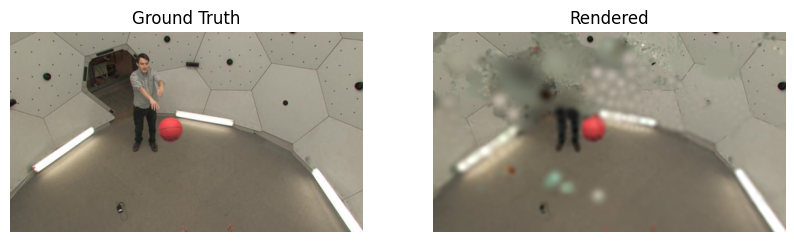

In [37]:
r = 6
im, _, _ = gm.render(cam=cams[r])
im = torch.clip(im, 0, 1)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(images[6].detach().cpu().numpy().transpose(1, 2, 0))
axs[0].set_title("Ground Truth")
axs[0].axis('off')
axs[1].imshow(im.detach().cpu().numpy().transpose(1, 2, 0))
axs[1].set_title("Rendered")
axs[1].axis('off')
plt.show()

In [25]:
images[0].shape

torch.Size([3, 294, 518])